# CORRECTIVE RAG LINKS
#### https://www.analyticsvidhya.com/blog/2024/02/how-to-enhance-rag-performance-with-crag/
#### https://www.analyticsvidhya.com/blog/2024/07/building-agentic-rag-systems-with-langgraph/

In [1]:
from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from typing import Annotated, Literal, Sequence, TypedDict
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph

load_dotenv()

True

In [2]:

import os
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [3]:
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
model = ChatGroq(groq_api_key=groq_api_key, model="llama-3.1-8b-instant", temperature=0)


/Users/subham/Desktop/GENAI/genai/crew_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load and split PDFs
documents = []
pdf_folder_path = "./"
for file_name in os.listdir(pdf_folder_path):
    if file_name.lower().endswith(".pdf"):
        file_path = os.path.join(pdf_folder_path, file_name)
        loader = PyPDFLoader(file_path)
        docs = loader.load()
        documents.extend(docs)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)



In [12]:
# ---------- Chroma Vector Store Setup ----------
persist_dir = "./chroma_db"  # make sure this folder is writable

vectorstore = Chroma.from_documents(
    documents=splits,
    collection_name="rag-chroma",
    embedding=embeddings,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory=persist_dir
)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                       search_kwargs={"k": 3,                                                                       
                       "score_threshold": 0.3})


## Create a Query Retrieval Grader
- Here, we will use an LLM itself to grade if any retrieved document is relevant to the given question – The answer will be either yes or no. The LLM, in our case, will be GPT-4o.

In [34]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
    
# LLM for grading
structured_llm_grader = model.with_structured_output(GradeDocuments)
# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}
                     User question:
                     {question}
                  """),
    ]
)
# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

## Build a QA RAG Chain
- Here, we will connect our retriever to an LLM, GPT-4o, in our case, and build our Question-answering RAG chain. Remember, this will be our traditional RAG system, which we will integrate with an AI Agent later.

In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.
            Question:
            {question}
            Context:
            {context}
            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    model
      |
    StrOutputParser()
)

## Create a Query Rephraser
- We will now build a query rephraser, which will use an LLM, GPT-4o in our case, to rephrase the input user query into a better version that is optimized for web search. This will help us get better context information from the web for our query.

In [36]:
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}
                     Formulate an improved question.
                  """,
        ),
    ]
)

# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       model
                        |
                     StrOutputParser())

## Load Web Search Tool
- Here, we will use the Tavily API for our web searches, so we load up a connection to this API. For our searches, we will use the top 3 search results as additional context information; however, you are free to load in more search results.

In [37]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)


## Build Agentic RAG components
- Here, we will build the key components of our Agentic Corrective RAG System as per the workflow we discussed earlier in our guide. These functions will be put into relevant agent nodes via LangGraph later on when we build our agent.

### Graph State
- This is used to store and represent the state of the agent graph as we traverse through various nodes. It will store and keep track of the user query, a flag variable telling us if a web search is needed, a list of context documents (retrieved from the vector database and \ or web search), and the LLM-generated response.

In [38]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB
- This will be used to get relevant context documents from the vector database using our retriever, which we built earlier. Remember, as this will be a node in the agent graph, later on, we will be getting the user question from the graph state and then pass it to our retriever to get relevant context documents from the vector database.

In [39]:
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

### Grade documents
- This will be used to determine whether the retrieved documents are relevant to the question using an LLM Grader. It sets the web_search_needed flag as Yes if at least one document is not contextually relevant OR no context documents were retrieved. Otherwise, it sets the flag as No if all documents are contextually relevant to the given user query. It updates the state graph by ensuring context documents consist of only relevant documents.

In [40]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.
    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"
    return {"documents": filtered_docs, "question": question, 
            "web_search_needed": web_search_needed}

### Rewrite query
- This will be used to rewrite the input query to produce a better question optimized for web search using an LLM, this will also update the query in the state graph so it can be accessed by other nodes in our agent graph which we will be creating shortly.

In [41]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web Search
- This will be used to search the web using the web search tool for the given query and retrieve some information from the web, which can be used as additional context documents in our RAG system. We will use the Tavily Search API tool in our system, as discussed earlier. This function also updates the state graph, especially the list of context documents, with new documents retrieved from the web for the rephrased user query.

In [42]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-written question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

### Generate Answer
- This is the standard LLM response generation function from query and context documents in an RAG system. We also update the generation field in the state graph so we can access it anytime in our agent graph and output the response to the user as needed.

In [43]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, 
            "generation": generation}

### Decide to Generate
- This will use this as a conditional function to check the web_search_needed flag from the agent graph state and decide whether to generate a web search or a response. It will return the function name to call. If a web search is necessary, the system returns the rewrite_query string, prompting our agentic RAG system to follow the flow of query rephrasing, search, and response generation. If a web search is unnecessary, the function will return the generate_answer string, enabling our RAG system to go into the regular flow of generating a response from the given context documents and query. You will use this function in the conditional node of our agent graph to route the flow to the correct function based on the two possible pathways.

In [44]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]
    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

### Build the Agent Graph with LangGraph
- Here, we will use LangGraph and build the agent as a graph using the functions we implemented in the previous section, put them in relevant nodes as per our Agentic RAG system architecture, and connect them with relevant edges as per the defined workflows

In [49]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
agentic_rag = StateGraph(GraphState)
# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer
# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)
# Compile
agentic_rag = agentic_rag.compile()

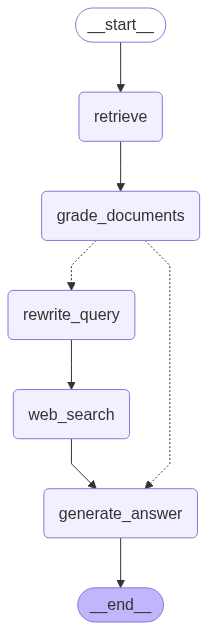

In [50]:
from IPython.display import display, Image, Markdown


try:
    display(Image(agentic_rag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
query = "What is attention mechanism?"
response = agentic_rag.invoke({"question": query})
display(Markdown(response['generation']))


---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


The attention mechanism is a concept in deep learning, particularly in the context of neural networks and natural language processing. According to the provided context, the attention mechanism is illustrated in Figure 3, which shows an example of the attention mechanism following long-distance dependencies in the encoder self-attention in layer 5 of 6.

In this context, the attention mechanism is used to attend to a distant dependency of the verb 'making', completing the phrase 'making...more difficult'. This suggests that the attention mechanism is used to focus on specific parts of the input sequence that are relevant to the task at hand, in this case, understanding the relationship between the verb 'making' and the phrase 'more difficult'.

In general, the attention mechanism is a technique used to weigh the importance of different elements in a sequence, such as words in a sentence, and use this weighting to compute a representation of the sequence. This can be useful in a variety of tasks, including machine translation, text summarization, and question answering.

In the context of the provided figures, the attention mechanism is visualized as different colors representing different heads, which suggests that the attention mechanism is composed of multiple attention heads that attend to different parts of the input sequence.

In [53]:
query = "Explain Retrieval-Augmented Generation in NLP."
response = agentic_rag.invoke({"question": query})
display(Markdown(response['generation']))


---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


Retrieval-Augmented Generation (RAG) is a technique in Natural Language Processing (NLP) that combines pre-trained parametric and non-parametric memory for language generation. The parametric memory is a pre-trained sequence-to-sequence (seq2seq) model, while the non-parametric memory is a dense vector index of Wikipedia, accessed with a pre-trained neural retriever.

In RAG, the model first retrieves relevant passages from the non-parametric memory (Wikipedia) using a pre-trained neural retriever. These retrieved passages are then used to augment the parametric memory (seq2seq model) for language generation. This allows the model to access and precisely manipulate knowledge from the non-parametric memory, which can be used to improve the quality and accuracy of the generated text.

There are two main formulations of RAG:

1. **Conditioning on retrieved passages across the whole generated sequence**: In this formulation, the model conditions on the same retrieved passages across the whole generated sequence.
2. **Using different passages per token**: In this formulation, the model can use different passages per token, allowing for more flexibility and diversity in the generated text.

RAG models have been shown to outperform parametric seq2seq models and task-specific retrieve-and-extract architectures on a wide range of knowledge-intensive NLP tasks, including open-domain QA tasks and language generation tasks. They generate more specific, diverse, and factual language than state-of-the-art parametric-only seq2seq baselines.

Overall, RAG is a powerful technique for addressing the limitations of pre-trained language models, such as their inability to easily expand or revise their memory, and their tendency to produce "hallucinations". By combining parametric and non-parametric memory, RAG models can access and precisely manipulate knowledge from a large external memory, leading to improved performance on knowledge-intensive NLP tasks.